In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets

from warnings import filterwarnings
filterwarnings('ignore')

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("guillemservera/global-daily-climate-data")

print("Path to dataset files:", path)

100%|████████████████████████████████████████| 213M/213M [01:25<00:00, 2.62MB/s]

Extracting files...


Path to dataset files: /Users/onurozdemir/.cache/kagglehub/datasets/guillemservera/global-daily-climate-data/versions/20


In [3]:
cities = pd.read_csv("cities.csv")
cities.head()

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300


## *** Countries ***

In [7]:
countries = pd.read_csv("countries.csv")
countries.head()

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100.0,652230.0,Kabul,34.526011,69.177684,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947.0,28748.0,Tirana,41.326873,19.818791,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000.0,2381741.0,Algiers,36.775361,3.060188,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519.0,199.0,Pago Pago,-14.275479,-170.704830,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301.0,1246700.0,Luanda,-8.827270,13.243951,Central Africa,Africa


In [6]:
daily_weather = pd.read_parquet("daily_weather.parquet")
daily_weather.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print("\n📌 Countries - Info:")
print(countries.info())


📌 Countries - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      214 non-null    object 
 1   native_name  213 non-null    object 
 2   iso2         213 non-null    object 
 3   iso3         214 non-null    object 
 4   population   210 non-null    float64
 5   area         207 non-null    float64
 6   capital      212 non-null    object 
 7   capital_lat  212 non-null    float64
 8   capital_lng  212 non-null    float64
 9   region       205 non-null    object 
 10  continent    206 non-null    object 
dtypes: float64(4), object(7)
memory usage: 18.5+ KB
None


In [17]:
countries.describe()

,population,area,capital_lat,capital_lng
count,2.100000e+02,2.070000e+02,212.000000,212.000000
mean,3.365144e+07,6.537604e+05,18.812330,16.545432
std,1.330461e+08,1.866909e+06,26.590545,69.625088
min,3.000000e+01,2.020000e+00,-54.283545,-176.174022
25%,7.572605e+05,1.306600e+04,2.874467,-13.375923
50%,6.315500e+06,1.098840e+05,18.025227,16.725786
75%,2.268378e+07,4.817710e+05,41.315970,47.637577
max,1.367110e+09,1.712444e+07,78.223156,179.118650


In [19]:
countries.isnull().sum()

country        0
native_name    1
iso2           1
iso3           0
population     4
area           7
capital        2
capital_lat    2
capital_lng    2
region         9
continent      8
dtype: int64

In [21]:
# Zuerst die Spalten "population" und "area" als Float konvertieren
countries['population'] = countries['population'].astype(float)
countries['area'] = countries['area'].astype(float)

# Fehlende Werte durch den Durchschnitt der jeweiligen Region ersetzen
countries['population'] = countries.groupby('region')['population'].transform(lambda x: x.fillna(x.mean()))
countries['area'] = countries.groupby('region')['area'].transform(lambda x: x.fillna(x.mean()))

# Falls es noch fehlende Werte gibt, ersetze sie durch den allgemeinen Durchschnitt
countries['population'] = countries['population'].fillna(countries['population'].mean())
countries['area'] = countries['area'].fillna(countries['area'].mean())

# Konvertiere die Spalten in ganze Zahlen (Integer)
countries['population'] = countries['population'].astype(int)
countries['area'] = countries['area'].astype(int)

# Die ersten Zeilen der aktualisierten Daten anzeigen
countries.head()

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100,652230,Kabul,34.526011,69.177684,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947,28748,Tirana,41.326873,19.818791,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000,2381741,Algiers,36.775361,3.060188,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519,199,Pago Pago,-14.275479,-170.704830,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301,1246700,Luanda,-8.827270,13.243951,Central Africa,Africa


In [23]:
# Die 5 Länder mit der größten Bevölkerung ermitteln
largest_population = countries.nlargest(5, "population")[["country", "population"]]

# Die 5 Länder mit der kleinsten Bevölkerung ermitteln
smallest_population = countries.nsmallest(5, "population")[["country", "population"]]

# Die 5 Länder mit der größten Fläche ermitteln
largest_area = countries.nlargest(5, "area")[["country", "area"]]

# Die 5 Länder mit der kleinsten Fläche ermitteln
smallest_area = countries.nsmallest(5, "area")[["country", "area"]]

# Länder mit möglicherweise fehlerhaften Bevölkerungswerten herausfiltern
invalid_population = countries[(countries["population"] <= 1000) | (countries["population"] > 1_500_000_000)]

# Länder mit möglicherweise fehlerhaften Flächenwerten herausfiltern
invalid_area = countries[(countries["area"] <= 10) | (countries["area"] > 17_000_000)]

# Ergebnisse ausgeben
print("\n--- Länder mit der größten Bevölkerung ---\n", largest_population)
print("\n--- Länder mit der kleinsten Bevölkerung ---\n", smallest_population)


--- Länder mit der größten Bevölkerung ---
            country  population
37           China  1367110000
85           India  1263930000
202  United States   319259000
86       Indonesia   252164800
24          Brazil   203586000

--- Länder mit der kleinsten Bevölkerung ---
                                  country  population
173                        South Georgia          30
65   French Southern and Antarctic Lands         140
38                      Christmas Island        2072
138                       Norfolk Island        2302
180               Svalbard and Jan Mayen        2562


In [25]:
print("\n--- Länder mit der größten Fläche ---\n", largest_area)
print("\n--- Länder mit der kleinsten Fläche ---\n", smallest_area)


--- Länder mit der größten Fläche ---
            country      area
154         Russia  17124442
31          Canada   9984670
37           China   9640011
202  United States   9629091
24          Brazil   8515767

--- Länder mit der kleinsten Fläche ---
             country  area
126          Monaco     2
197          Tuvalu    26
112           Macau    30
138  Norfolk Island    36
19          Bermuda    54


In [27]:
print("\n--- Verdächtige Bevölkerungswerte ---\n", invalid_population)
print("\n--- Verdächtige Flächenwerte ---\n", invalid_area)


--- Verdächtige Bevölkerungswerte ---
                                  country  \
65   French Southern and Antarctic Lands   
173                        South Georgia   

                                           native_name iso2 iso3  population  \
65   Territoire des Terres australes et antarctique...   TF  ATF         140   
173                                      South Georgia   GS  SGS          30   

     area            capital  capital_lat  capital_lng      region   continent  
65   7747  Port-aux-Français   -49.353677    70.243567  Antarctica  Antarctica  
173  7747  King Edward Point   -54.283545   -36.494636  Antarctica  Antarctica  

--- Verdächtige Flächenwerte ---
     country native_name iso2 iso3  population      area capital  capital_lat  \
126  Monaco      Monaco   MC  MCO       36950         2  Monaco    43.732349   
154  Russia      Россия   RU  RUS   146233000  17124442  Moscow    55.750446   

     capital_lng          region continent  
126     7.427683  West

In [29]:
print(countries.isnull().sum())

country        0
native_name    1
iso2           1
iso3           0
population     0
area           0
capital        2
capital_lat    2
capital_lng    2
region         9
continent      8
dtype: int64


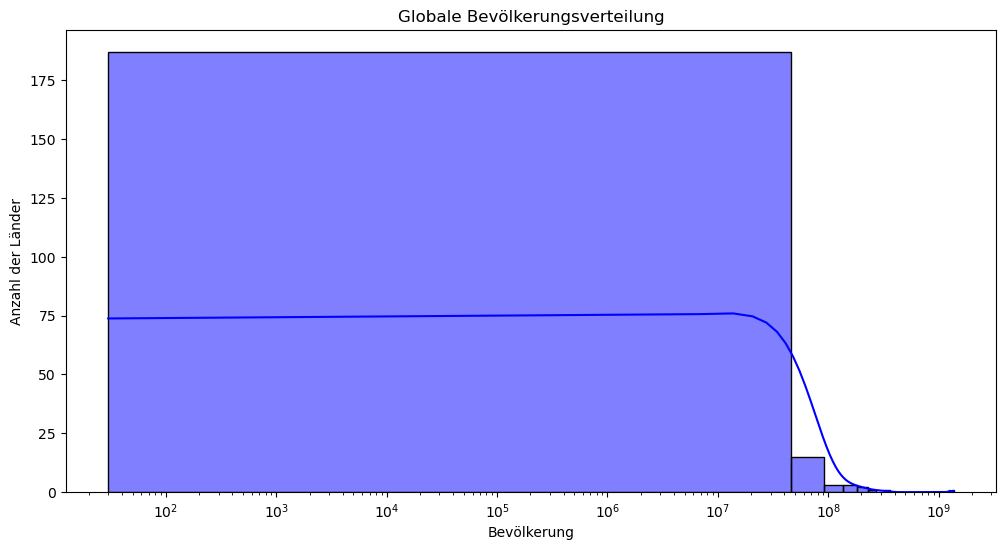

In [31]:
# Histogramm (Bevölkerungsverteilung aller Länder)
plt.figure(figsize=(12, 6))  # Größe der Grafik festlegen

# Erstellen eines Histogramms zur Anzeige der Bevölkerungsverteilung
sns.histplot(countries["population"], bins=30, kde=True, color="blue")

# Achsenbeschriftungen hinzufügen
plt.xlabel("Bevölkerung")  # X-Achse: Bevölkerung (Population)
plt.ylabel("Anzahl der Länder")  # Y-Achse: Anzahl der Länder in jeder Bevölkerungsgruppe

# Titel für die Grafik setzen
plt.title("Globale Bevölkerungsverteilung")  # Titel des Diagramms

# Logarithmische Skala für die X-Achse verwenden, um große Unterschiede besser darzustellen
plt.xscale("log")  

# Diagramm anzeigen
plt.show()


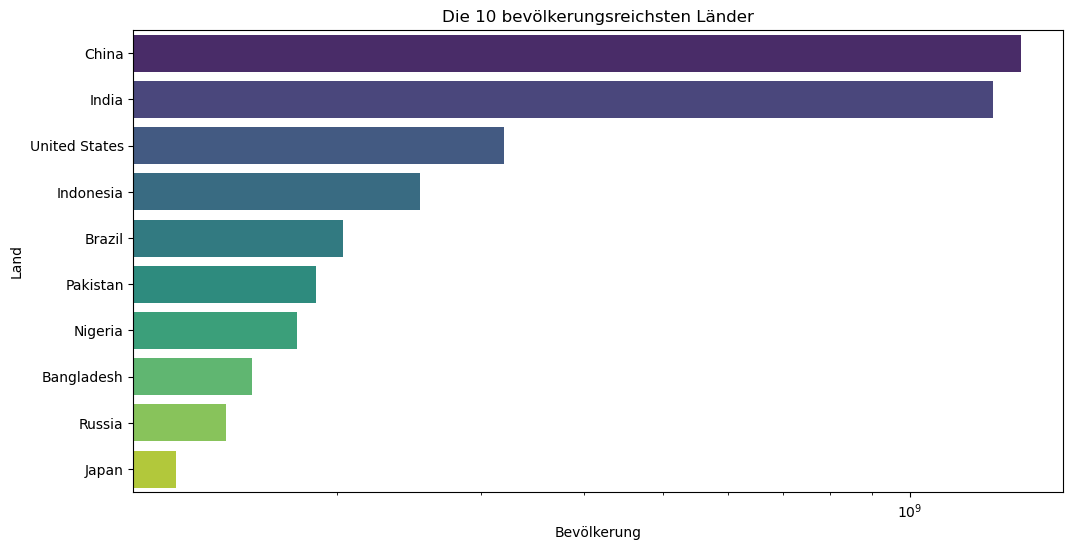

In [33]:
# Die 10 bevölkerungsreichsten Länder auswählen
top_population = countries.nlargest(10, "population")

# Größe der Grafik festlegen
plt.figure(figsize=(12, 6))

# Balkendiagramm zur Darstellung der 10 bevölkerungsreichsten Länder erstellen
sns.barplot(y=top_population["country"], x=top_population["population"], palette="viridis")

# Achsenbeschriftungen hinzufügen
plt.xlabel("Bevölkerung")  # X-Achse: Bevölkerung (Population)
plt.ylabel("Land")  # Y-Achse: Länder

# Titel für das Diagramm setzen
plt.title("Die 10 bevölkerungsreichsten Länder")

# Logarithmische Skala für die X-Achse verwenden, um große Unterschiede besser darzustellen
plt.xscale("log")  

# Diagramm anzeigen
plt.show()


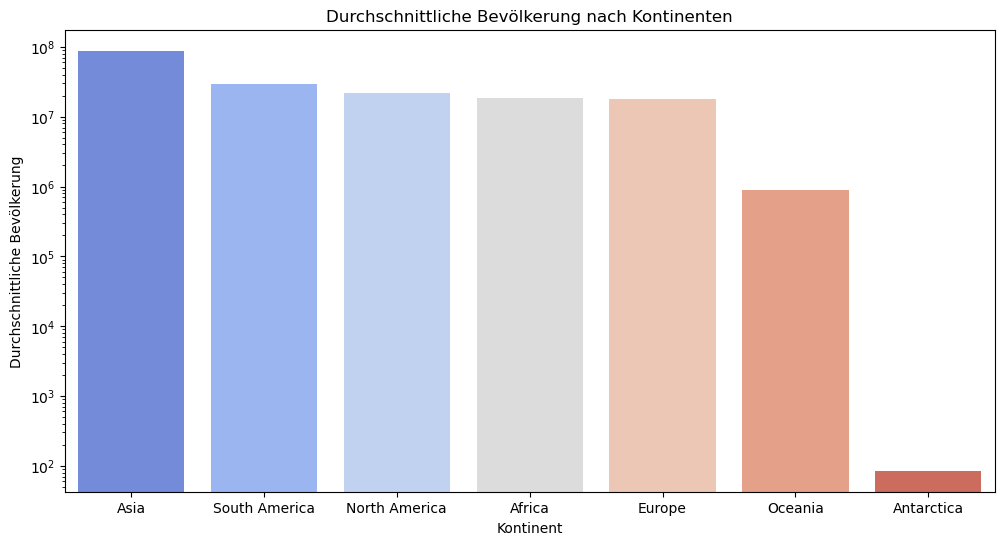

In [36]:
# Größe der Grafik festlegen
plt.figure(figsize=(12, 6))

# Durchschnittliche Bevölkerung pro Kontinent berechnen und absteigend sortieren
continent_population = countries.groupby("continent")["population"].mean().sort_values(ascending=False)

# Balkendiagramm zur Darstellung der durchschnittlichen Bevölkerung pro Kontinent erstellen
sns.barplot(x=continent_population.index, y=continent_population.values, palette="coolwarm")

# Achsenbeschriftungen hinzufügen
plt.xlabel("Kontinent")  # X-Achse: Kontinent
plt.ylabel("Durchschnittliche Bevölkerung")  # Y-Achse: Durchschnittliche Bevölkerung pro Kontinent

# Titel für das Diagramm setzen
plt.title("Durchschnittliche Bevölkerung nach Kontinenten")

# Logarithmische Skala für die Y-Achse verwenden, um große Unterschiede besser darzustellen
plt.yscale("log")  

# Diagramm anzeigen
plt.show()


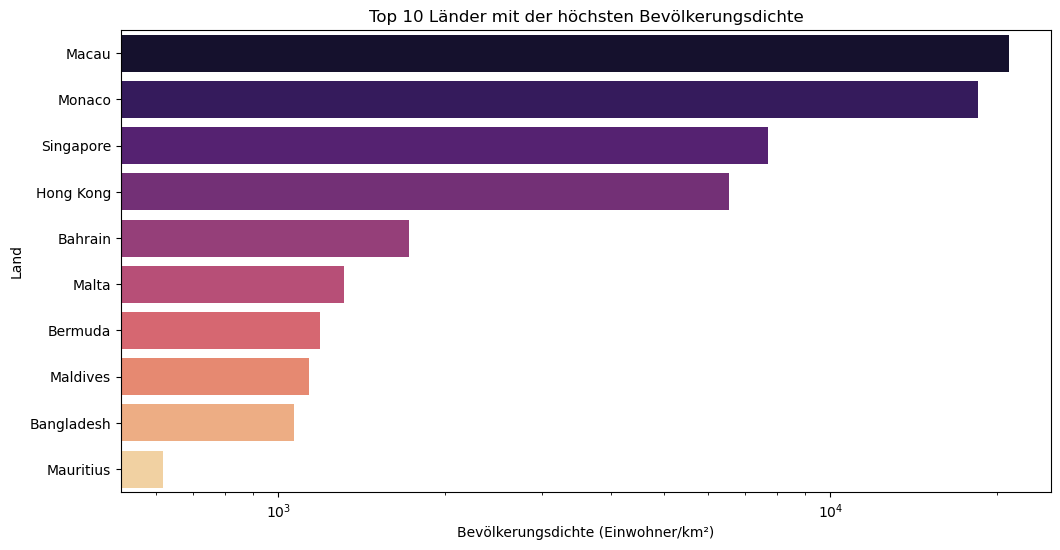

In [38]:
# Bevölkerungsdichte berechnen (Bevölkerung / Fläche)
# Falls die Fläche 0 ist, wird sie durch 1 ersetzt, um eine Division durch Null zu vermeiden
countries["population_density"] = countries["population"] / countries["area"].replace(0, 1)  

# Die 10 Länder mit der höchsten Bevölkerungsdichte auswählen
top_density = countries.nlargest(10, "population_density")

# Größe der Grafik festlegen
plt.figure(figsize=(12, 6))

# Balkendiagramm zur Darstellung der Länder mit der höchsten Bevölkerungsdichte erstellen
sns.barplot(y=top_density["country"], x=top_density["population_density"], palette="magma")

# Achsenbeschriftungen hinzufügen
plt.xlabel("Bevölkerungsdichte (Einwohner/km²)")  # X-Achse: Bevölkerungsdichte
plt.ylabel("Land")  # Y-Achse: Länder

# Titel für das Diagramm setzen
plt.title("Top 10 Länder mit der höchsten Bevölkerungsdichte")

# Logarithmische Skala für die X-Achse verwenden, um große Unterschiede besser darzustellen
plt.xscale("log")

# Diagramm anzeigen
plt.show()


In [103]:

# Startpunkt der Karte und Zoom-Stufe festlegen
country_map = folium.Map(location=[20, 0], zoom_start=2)

# Länder auf der Karte hinzufügen
for index, row in countries.iterrows():
    if pd.notnull(row["capital_lat"]) and pd.notnull(row["capital_lng"]):  # Nur gültige Koordinaten verwenden
        folium.Marker(
            location=[row["capital_lat"], row["capital_lng"]],  # Koordinaten der Hauptstadt
            popup=f"{row['country']} (Hauptstadt: {row['capital']})\nBevölkerung: {row['population']:,}",  # Zusatzinformationen
            tooltip=row["country"],  # Name des Landes als Tooltip anzeigen
            icon=folium.Icon(color="blue", icon="info-sign"),  # Blaue Icons für Länder
        ).add_to(country_map)

# Die interaktive Karte direkt im Notebook anzeigen
country_map



## *** Cities ***

In [40]:
cities.head()

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300


In [42]:
print("\n📌 Cities - Info:")
print(cities.info())


📌 Cities - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  1245 non-null   object 
 1   city_name   1244 non-null   object 
 2   country     1245 non-null   object 
 3   state       1217 non-null   object 
 4   iso2        1239 non-null   object 
 5   iso3        1245 non-null   object 
 6   latitude    1245 non-null   float64
 7   longitude   1245 non-null   float64
dtypes: float64(2), object(6)
memory usage: 77.9+ KB
None


In [48]:
cities.isnull().sum()

station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64

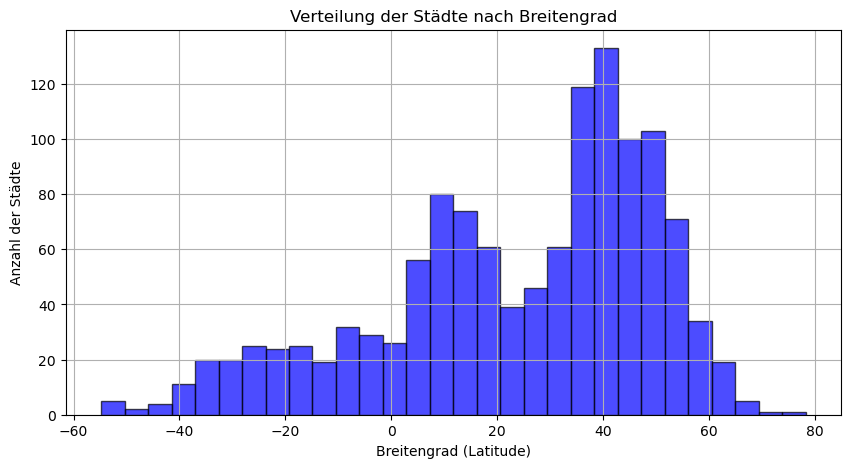

In [109]:
# Erstelle eine neue Abbildung mit einer bestimmten Größe
plt.figure(figsize=(10, 5))

# Erstelle ein Histogramm für die Breitengrade der Städte
plt.hist(cities["latitude"], bins=30, color="blue", alpha=0.7, edgecolor="black")

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel("Breitengrad (Latitude)")
plt.ylabel("Anzahl der Städte")
plt.title("Verteilung der Städte nach Breitengrad")

# Gitterlinien aktivieren
plt.grid(True)

# Diagramm anzeigen
plt.show()


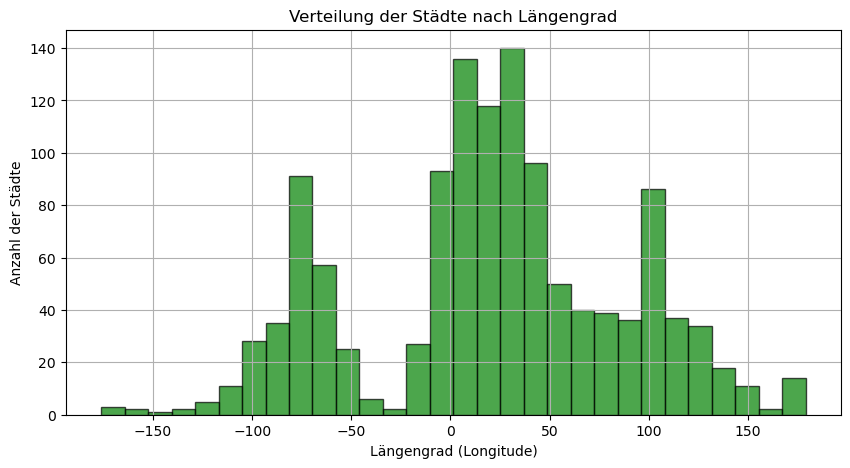

In [111]:

# Erstelle eine neue Abbildung mit einer bestimmten Größe
plt.figure(figsize=(10, 5))

# Erstelle ein Histogramm für die Längengrade der Städte
plt.hist(cities["longitude"], bins=30, color="green", alpha=0.7, edgecolor="black")

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel("Längengrad (Longitude)")
plt.ylabel("Anzahl der Städte")
plt.title("Verteilung der Städte nach Längengrad")

# Gitterlinien aktivieren
plt.grid(True)

# Diagramm anzeigen
plt.show()



In [99]:
import folium

# Haritanın başlangıç merkezi ve yakınlaştırma seviyesi
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Şehirleri harita üzerine ekleyelim
for index, row in cities.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
    ).add_to(world_map)

# Haritayı notebook içinde görüntüle
world_map

